In [2]:
#Imports & Setup
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
DATA_PATH = r"data/flowers"
BATCH_SIZE = 32
IMG_SIZE = 224

# Аугментація для тренування (збагачуємо дані)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Для валідації - тільки стандартна обробка
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Завантаження та спліт
try:
    full_dataset = datasets.ImageFolder(DATA_PATH)
    num_classes = len(full_dataset.classes)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    # Ми створюємо окремі класи Dataset, щоб не конфліктували трансформації
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y
        def __len__(self):
            return len(self.subset)

    train_ds = TransformedSubset(train_subset, transform=train_transform)
    val_ds = TransformedSubset(val_subset, transform=val_transform)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

    print(f"Data loaded. Classes: {full_dataset.classes}")
    print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)}")

except Exception as e:
    print(f"Error: {e}")

Data loaded. Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Train size: 3453 | Val size: 864


In [4]:
# Імпорти
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from models.transfer_models import get_resnet18, get_densenet121

print("Models successfully imported from file!")

Models successfully imported from file!


In [5]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / labels.size(0)

def plot_training_history(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Training ResNet18_FeatureExtract...
Ep 1/20 | Train Acc: 0.2748 | Train Loss: 1.6037 | Val Acc: 0.4074 | Val Loss: 1.4181
Ep 2/20 | Train Acc: 0.5242 | Train Loss: 1.2935 | Val Acc: 0.6343 | Val Loss: 1.1445
Ep 3/20 | Train Acc: 0.6617 | Train Loss: 1.0937 | Val Acc: 0.7315 | Val Loss: 0.9584
Ep 4/20 | Train Acc: 0.7344 | Train Loss: 0.9512 | Val Acc: 0.7859 | Val Loss: 0.8343
Ep 5/20 | Train Acc: 0.7588 | Train Loss: 0.8636 | Val Acc: 0.8067 | Val Loss: 0.7555
Ep 6/20 | Train Acc: 0.7863 | Train Loss: 0.7788 | Val Acc: 0.8090 | Val Loss: 0.6959
Ep 7/20 | Train Acc: 0.7926 | Train Loss: 0.7313 | Val Acc: 0.8322 | Val Loss: 0.6430
Ep 8/20 | Train Acc: 0.8094 | Train Loss: 0.6891 | Val Acc: 0.8391 | Val Loss: 0.6053
Ep 9/20 | Train Acc: 0.8149 | Train Loss: 0.6515 | Val Acc: 0.8403 | Val Loss: 0.5819
Ep 10/20 | Train Acc: 0.8196 | Train Loss: 0.6215 | Val Acc: 0.8495 | Val Loss: 0.5522
Ep 11/20 | Train Acc: 0.8254 | Train Loss: 0.5955 | Val Acc: 0.8553 | Val Loss: 0.5253
Ep 12/20 | Train

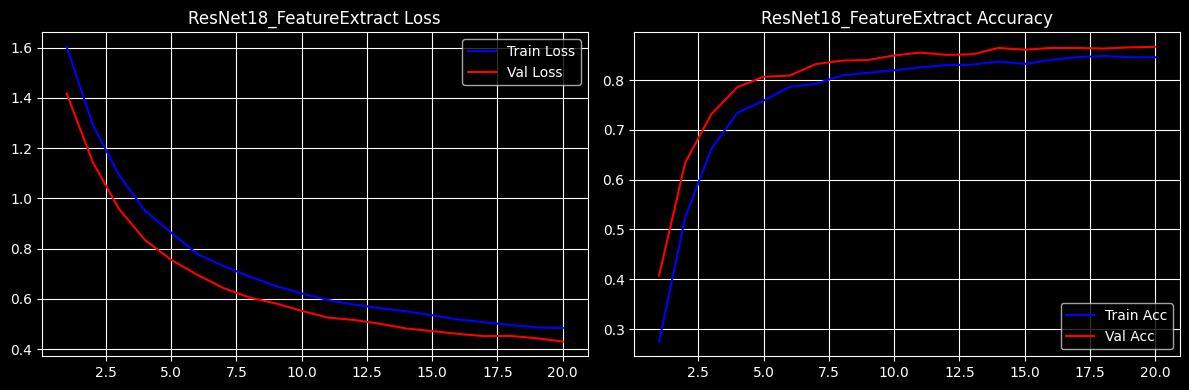

Best Accuracy: 0.8669


In [6]:
# --- ЕКСПЕРИМЕНТ 1: ResNet18 Feature Extraction ---
MODEL_NAME = "ResNet18_FeatureExtract"
EPOCHS = 20

print(f"Training {MODEL_NAME}...")

# 1. Завантаження моделі (Заморожена)
model = get_resnet18(feature_extract=True, num_classes=num_classes).to(device)

# 2. Оптимізатор (Вчимо тільки params, де requires_grad=True)
params_to_update = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.Adam(params_to_update, lr=1e-4)
criterion = nn.CrossEntropyLoss()

# 3. Цикл навчання
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss, train_acc, n_train = 0, 0, 0
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_acc += calculate_accuracy(outputs, labels) * imgs.size(0)
        n_train += imgs.size(0)

    # Val
    model.eval()
    val_loss, val_acc, n_val = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_acc += calculate_accuracy(outputs, labels) * imgs.size(0)
            n_val += imgs.size(0)

    # Log
    history['train_loss'].append(train_loss / n_train)
    history['val_loss'].append(val_loss / n_val)
    history['train_acc'].append(train_acc / n_train)
    history['val_acc'].append(val_acc / n_val)

    epoch_acc = val_acc / n_val
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(model.state_dict(), "checkpoints/resnet18_fe_best.pth")

    print(f"Ep {epoch+1}/{EPOCHS} | Train Acc: {train_acc/n_train:.4f} | Train Loss: {train_loss/ n_train:.4f} | Val Acc: {epoch_acc:.4f} | Val Loss: {val_loss/n_val:.4f}")
plot_training_history(history, MODEL_NAME)
print(f"Best Accuracy: {best_acc:.4f}")

In [7]:
import os

# Переконайся, що папка існує
os.makedirs("results", exist_ok=True)

# Функція для збереження
def save_plot(history, filename):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend(); plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend(); plt.grid(True)

    # ЗБЕРЕЖЕННЯ
    save_path = os.path.join("results", filename)
    plt.savefig(save_path)
    print(f"Графік збережено: {save_path}")
    plt.close()

# Викликаємо для поточної моделі (зміни назву файлу під кожен ноутбук!)
# Наприклад для 2.1: filename="resnet18_fe.png"
save_plot(history, f"{MODEL_NAME}.png")

Графік збережено: results\ResNet18_FeatureExtract.png
